In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import pickle # To save the model
from functools import partial
import random



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


import os
from os.path import isfile

--2024-03-18 09:52:59--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.72K  --.-KB/s    in 0s      

2024-03-18 09:52:59 (96.6 MB/s) - ‘visualization.py’ saved [13023/13023]



# Download the dataset and train/test split

Load the dataset

In [ ]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2024-03-18 09:53:11--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.04s   

2024-03-18 09:53:11 (6.59 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2024-03-18 09:53:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443

In [ ]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()
print (data)

[[1.83684800e+06 1.90327023e+08 1.16151881e+08 ... 2.59473178e+08
  1.00265909e+02 0.00000000e+00]
 [1.85564100e+06 1.90782590e+08 1.16159726e+08 ... 2.59522865e+08
  1.00276024e+02 0.00000000e+00]
 [1.85637300e+06 1.90688064e+08 1.16229597e+08 ... 2.59533231e+08
  1.00281822e+02 0.00000000e+00]
 ...
 [4.63221500e+06 1.75145145e+08 9.35510160e+07 ... 2.59453245e+08
  1.00262788e+02 2.00000000e+00]
 [4.64478900e+06 1.75105471e+08 9.33248380e+07 ... 2.59444187e+08
  1.00259509e+02 2.00000000e+00]
 [4.63646600e+06 1.75154689e+08 9.35143800e+07 ... 2.59458785e+08
  1.00264199e+02 2.00000000e+00]]


In [ ]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,...,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,...,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,259473178.0,100.265909,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,...,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,259522865.0,100.276024,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,...,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,259533231.0,100.281822,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,...,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,259571508.0,100.270504,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,...,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,259490859.0,100.270495,0


In [ ]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 32)
Possible labels  [0 1 2]


In [ ]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

# Pre-processing
## Full Data

In [ ]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()

In [ ]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

In [ ]:
# We separate the last column in
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [ ]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [ ]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/'

Mounted at /content/gdrive


#Logistic Regression

In [ ]:
import time
logistic_reg_acc = []
logistic_reg_prec = []
training_duration = []
execution_duration = []
for i in range(100):
  start_time = time.time()  # Record the start time
  model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=600)
  model.fit(train_x, train_y)
  end_time = time.time()  # Record the end time

  training_duration.append(end_time - start_time )  # Append the duration to the list

  start = time.time()
  y_pred = model.predict(test_x)
  end = time.time()
  execution_duration.append(end-start)

  class_names = np.array(["low", "mid", "high"] )
  #plot_conf_mat(test_y, y_pred, class_names)
  accuracy = accuracy_score(test_y, y_pred)
  precision = precision_score(test_y, y_pred, average='weighted')


  logistic_reg_acc.append(accuracy)
  logistic_reg_prec.append(precision)

In [ ]:
# Compute the averages
avg_training_duration = np.mean(training_duration)
avg_execution_duration = np.mean(execution_duration)
avg_lr_acc = np.mean(logistic_reg_acc)
avg_lr_prec = np.mean(logistic_reg_prec)

# Print the averages
print(f"Average Training Duration for Logistic Regression: {avg_training_duration} minutes")
print(f"Average Execution Duration forLogistic Regression: {avg_execution_duration} minutes")
print(f"Average Accuracy for Logistic Regression: {avg_lr_acc}")
print(f"Average Precision for Logistic Regression: {avg_lr_prec}")

Average Training Duration for Logistic Regression: 0.4795297884941101 minutes
Average Execution Duration forLogistic Regression: 0.000670006275177002 minutes
Average Accuracy for Logistic Regression: 0.8111587982832618
Average Precision for Logistic Regression: 0.8282356765339959


# Decision Tree Classifier


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
training_duration_dt = []
execution_duration_dt = []
dt_prec = []
dt_acc = []

for i in range(100):
  start = time.time()
  model = DecisionTreeClassifier(random_state=42)
  # Train the model
  model.fit(train_x, train_y)
  end = time.time()

  training_duration_dt.append(end - start)

  # Evaluate the model on the test set
  start_time = time.time()
  y_pred_dt = model.predict(test_x)
  end_time = time.time()

  execution_duration_dt.append(end_time-start_time)
  accuracy = accuracy_score(test_y, y_pred_dt)
  precision = precision_score(test_y, y_pred_dt, average='weighted')


  dt_acc.append(accuracy)
  dt_prec.append(precision)

  class_names = np.array(["low load", "mid load", "high load"])

  #plot_conf_mat(test_y, y_pred_dt, class_names)

In [ ]:
# Compute the averages
avg_training_duration_dt = np.mean(training_duration_dt)
avg_execution_duration_dt = np.mean(execution_duration_dt)
avg_dt_acc = np.mean(dt_acc)
avg_dt_prec = np.mean(dt_prec)

# Print the averages
print(f"Average Training Duration for Decision Tree: {avg_training_duration_dt} minutes")
print(f"Average Execution Duration for Decision Tree: {avg_execution_duration_dt} minutes")
print(f"Average Accuracy for Decision Tree: {avg_dt_acc}")
print(f"Average Precision for Decision Tree: {avg_dt_prec}")

Average Training Duration for Decision Tree: 0.08363003015518189 minutes
Average Execution Duration for Decision Tree: 0.000526282787322998 minutes
Average Accuracy for Decision Tree: 0.9896995708154503
Average Precision for Decision Tree: 0.9897066327928008


#Random Forest Classifier


In [ ]:
training_duration_rf = []
execution_duration_rf = []
rf_acc = []
rf_prec = []

for i in range(100):
  start = time.time()
  model = RandomForestClassifier(n_estimators=100, random_state=42)

  # Train the model
  model.fit(train_x, train_y)
  end = time.time()

  training_duration_rf.append(end - start)

  # Evaluate the model on the test set
  start_time = time.time()
  y_pred_rf = model.predict(test_x)
  end_time = time.time()

  execution_duration_rf.append(end_time-start_time)
  accuracy = accuracy_score(test_y, y_pred_rf)
  precision = precision_score(test_y, y_pred_rf, average='weighted')


  rf_acc.append(accuracy)
  rf_prec.append(precision)

  class_names = np.array(["low load", "mid load", "high load"])

  #plot_conf_mat(test_y, y_pred_rf, class_names)

In [ ]:
# Compute the averages
avg_training_duration_rf = np.mean(training_duration_rf)
avg_execution_duration_rf = np.mean(execution_duration_rf)
avg_rf_acc = np.mean(rf_acc)
avg_rf_prec = np.mean(rf_prec)

# Print the averages
print(f"Average Training Duration for Random Forest: {avg_training_duration_rf} minutes")
print(f"Average Execution Duration for Random Forest: {avg_execution_duration_rf} minutes")
print(f"Average Accuracy for Random Forest: {avg_rf_acc}")
print(f"Average Precision for Random Forest: {avg_rf_prec}")

Average Training Duration for Random Forest: 1.2044620251655578 minutes
Average Execution Duration for Random Forest: 0.01779468059539795 minutes
Average Accuracy for Random Forest: 0.9957081545064377
Average Precision for Random Forest: 0.9957245195475382


# SVM

In [ ]:
from sklearn.svm import SVC

training_duration_svm = []
execution_duration_svm = []
svm_prec = []
svm_acc = []
for i in range(100):

  start = time.time()
  # Build the Support Vector Machine model
  svm_model = SVC(kernel='linear', C=3, gamma='auto')

  # Train the model
  svm_model.fit(train_x, train_y)
  end = time.time()

  training_duration_svm.append(end - start)

  # Evaluate the model on the test set
  start = time.time()
  y_pred_svm = svm_model.predict(test_x)
  end = time.time()

  execution_duration_svm.append(end-start)

  accuracy = accuracy_score(test_y, y_pred_svm)
  precision = precision_score(test_y, y_pred_svm, average='weighted')


  svm_acc.append(accuracy)
  svm_prec.append(precision)


  # Assuming class names are the same for SVM as they were for KNN
  class_names = np.array(["low load", "mid load", "high load"])

  #plot_conf_mat(test_y, y_pred_svm, class_names)

In [ ]:
# Compute the averages
avg_training_duration_svm = np.mean(training_duration_svm)
avg_execution_duration_svm = np.mean(execution_duration_svm)
avg_svm_acc = np.mean(svm_acc)
avg_svm_prec = np.mean(svm_prec)

# Print the averages
print(f"Average Training Duration for SVM: {avg_training_duration_svm} minutes")
print(f"Average Execution Duration for SVM: {avg_execution_duration_svm} minutes")
print(f"Average Accuracy for SVM: {avg_svm_acc}")
print(f"Average Precision for SVM: {avg_svm_prec}")

Average Training Duration for SVM: 0.655880982875824 minutes
Average Execution Duration for SVM: 0.10375763654708862 minutes
Average Accuracy for SVM: 0.8145922746781113
Average Precision for SVM: 0.8617873451976362


# 1st Neural Network

If you use Neural Networks, in Colab do "Runtime > Change Runtime type" to TPU or GPU.

The functions `build_model()` and `train_model(..)` are very similar to what you encountered in the [notebooks on Neural Networks](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [ ]:
def make_sequential_model(sample_size, layer_sizes,
                          hidden_activation_function="relu",
                          out_activation_function="softmax",
                          loss_fun="sparse_categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0],
                  input_dim = sample_size) )

  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )

  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )


  model.compile(loss=loss_fun,
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)

  return model


def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more:
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))


def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000,
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training
            (thanks to the ModelCheckpoint callback (see the implementation
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.

  overwrite: boolean
            If true, the model will be built and trained from scratch,
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the
            specified number of epochs
  """

  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True)


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs,
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb],
                      validation_split=validation_split )

  return history

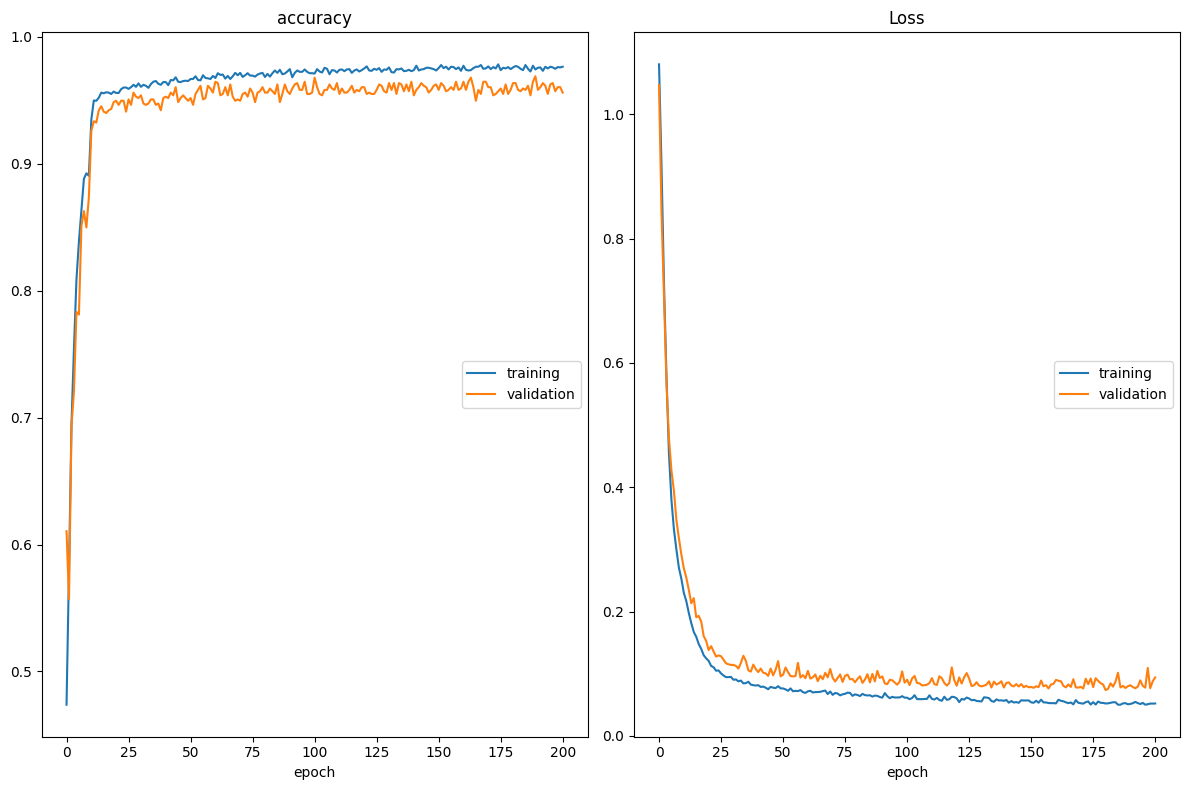

accuracy
	training         	 (min:    0.474, max:    0.978, cur:    0.976)
	validation       	 (min:    0.557, max:    0.969, cur:    0.956)
Loss
	training         	 (min:    0.050, max:    1.081, cur:    0.052)
	validation       	 (min:    0.074, max:    1.047, cur:    0.094)
Restoring model weights from the end of the best epoch: 181.
117/117 [==============================] - 1s 10ms/step - loss: 0.0520 - accuracy: 0.9764 - val_loss: 0.0940 - val_accuracy: 0.9560
Epoch 201: early stopping
37/37 [==============================] - 0s 2ms/step


In [ ]:
import time

training_duration_nn = []
execution_duration_nn = []
nn_prec = []
nn_acc = []

for i in range(10):
  sample_size = train_x.shape[1]
  num_of_classes=3
  nnfile = nn_file = my_path + f"nn{i+1}.h5"
  shallow_architecture=[20, 10, 5, num_of_classes]

  start = time.time()
  model = make_sequential_model(sample_size, shallow_architecture)
  history = train_model(model, nn_file, train_x, train_y, seed=3)
  end = time.time()

  training_duration_nn.append(end - start)
  start_time = time.time()
  y_pred_ = model.predict(test_x)
  end_time = time.time()
  execution_duration_nn.append(end_time-start_time)

  y_pred = np.argmax(y_pred_, axis=1)
#plot_conf_mat(test_y, y_pred, class_names)
  accuracy = accuracy_score(test_y, y_pred)
  precision = precision_score(test_y, y_pred, average='weighted')


  nn_acc.append(accuracy)
  nn_prec.append(precision)

In [ ]:
# Compute the averages
avg_training_duration_nn = np.mean(training_duration_nn)
avg_execution_duration_nn = np.mean(execution_duration_nn)
avg_nn_acc = np.mean(nn_acc)
avg_nn_prec = np.mean(nn_prec)

# Print the averages
print(f"Average Training Duration for NN: {avg_training_duration_nn} minutes")
print(f"Average Execution Duration for NN: {avg_execution_duration_nn} minutes")
print(f"Average Accuracy for NN: {avg_nn_acc}")
print(f"Average Precision for NN: {avg_nn_prec}")

Average Training Duration for NN: 234.07843301296234 minutes
Average Execution Duration for NN: 13.671960186958312 minutes
Average Accuracy for NN: 0.9679828326180259
Average Precision for NN: 0.9682620273764982
